<a href="https://colab.research.google.com/github/RanaMudassarRasool/Deeplearning/blob/main/lumpy_skin_disease_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Detection Of Lumpy Skin Disease Using Deep Learning

In [3]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Base Path for all files
data_dir = '/content/drive/MyDrive/LumpySkin ImagesDataset'

**Load Images For Training & Testing**

In [5]:
###### Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 922 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


**Initialize Densenet-121 Pretrained Model**

In [7]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = DenseNet121(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('/content/drive/MyDrive/DenseNet-BC-121-32-no-top.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

**Add Custom Layer**

In [8]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [9]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

**View Model Summary & Plot**

In [10]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 8,089,154
Trainable params: 1,051,650
Non-trainable params: 7,037,504
______________________________________

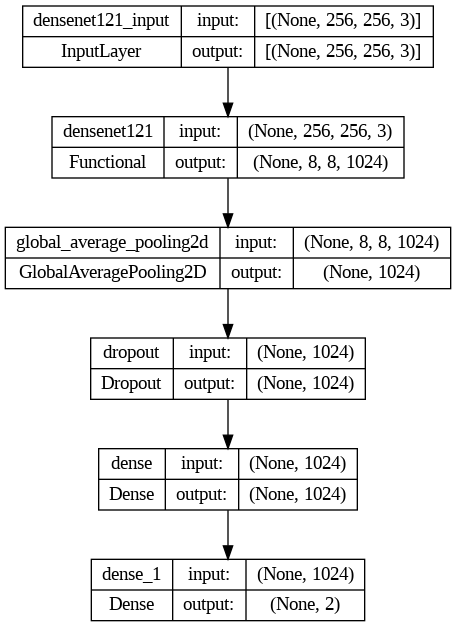

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

**Model Building**

In [12]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [13]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 28
validation_steps : 3


**Model Training**

In [14]:
# File Path to store the trained models
filepath = "model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.6831 
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to model_01-0.83.h5
28/28 [==============================] - 388s 13s/step - loss: 0.6038 - accuracy: 0.6831 - val_loss: 0.3488 - val_accuracy: 0.8333
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8180
Epoch 2: val_accuracy improved from 0.83333 to 0.84375, saving model to model_02-0.84.h5
28/28 [==============================] - 277s 10s/step - loss: 0.4276 - accuracy: 0.8180 - val_loss: 0.2975 - val_accuracy: 0.8438
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.8337
Epoch 3: val_accuracy improved from 0.84375 to 0.90625, saving model to model_03-0.91.h5
28/28 [==============================] - 285s 10s/step - loss: 0.3820 - accuracy: 0.8337 - val_loss: 0.2317 - val_accuracy: 0.9062
Epoch 4/10
28/28 [==============================] - ETA: 0s 

 **Model Evaluation**

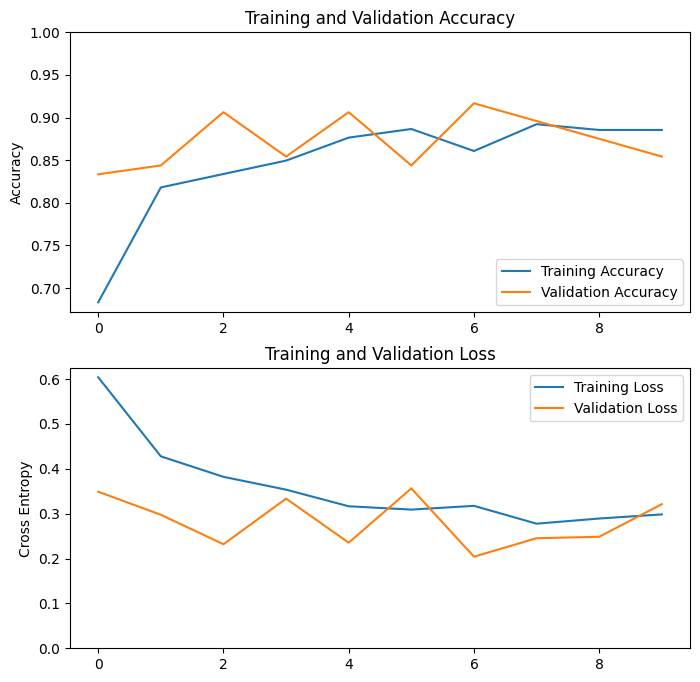

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


In [16]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

4/4 [==============================] - 26s 6s/step - loss: 0.3164 - accuracy: 0.8529
test accuracy :  0.8529411554336548


In [17]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("model_07-0.92.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()


**Model Testing With Graphs**

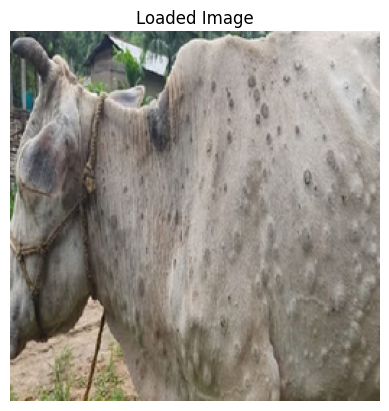

1/1 [==============================] - 3s 3s/step


Maximum Probability:  0.9760902
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 97.61 %
NORMAL SKIN : 2.39 %


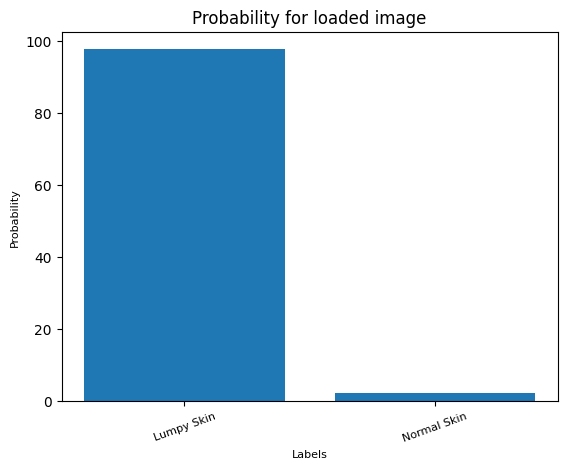

In [18]:
predict("Lumpy_Skin_9.png")

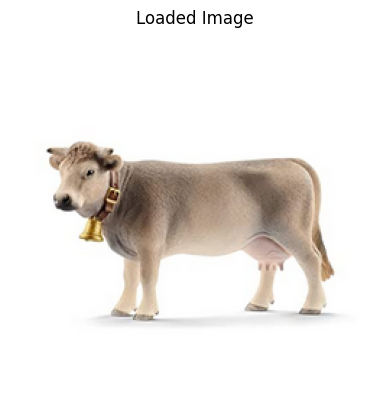

1/1 [==============================] - 0s 220ms/step


Maximum Probability:  0.95967835
Classified: Normal Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 4.03 %
NORMAL SKIN : 95.97 %


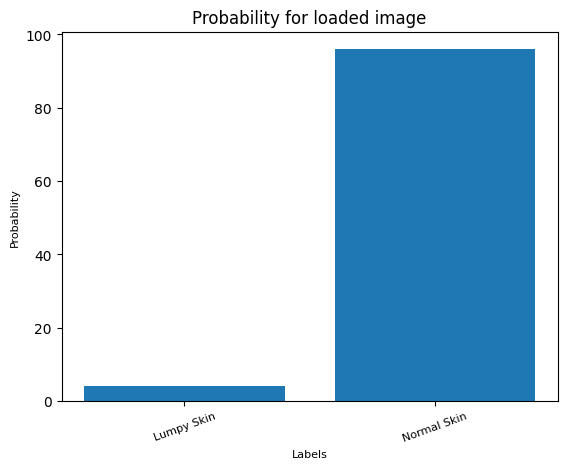

In [19]:
predict("Normal_Skin_18.png")

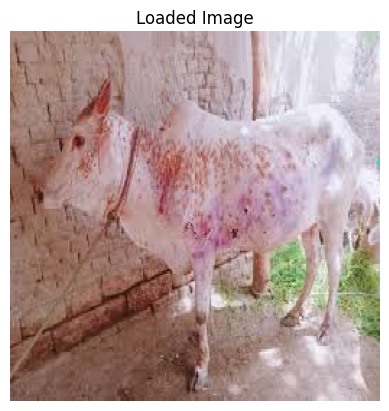

1/1 [==============================] - 0s 249ms/step


Maximum Probability:  0.99594986
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 99.59 %
NORMAL SKIN : 0.41 %


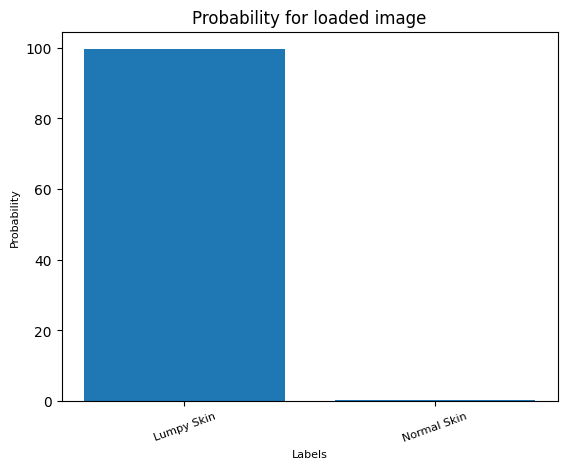

In [20]:
predict("ld.jpg")